# Tutorial: The Neocortical Microcircuit Collaboration Portal

Blue Brain Project / EPFL ©2005-2021. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.

The Neocortical Microcircuit Collaboration Portal (NMC Portal, at [https://bbp.epfl.ch/nmc-portal](https://bbp.epfl.ch/nmc-portal)) provides an online public resource of the Blue Brain Project's first release of a digital reconstruction of the microcircuitry of juvenile Rat somatosensory cortex, access to experimental data sets used in the reconstruction, and the resulting single cell models.

![NMC Portal web page](https://bbp.epfl.ch/public/SimNeuroMOOC/images/NMCPortal/NMCWeb.png)

In this tutorial we will focus on working with the electrical models of single neurons one can download from the NMC portal.

Let's begin with importing useful Python packages

In [1]:
import os
os.unsetenv('PYTHONHOME') # Solve an issue with NEURON simulator import
!pip install -q bluepyopt==1.5.12 matplotlib==2.0.2 numpy==1.13.0 neurom==1.4.2 2>&1 | grep -v 'SNIMissingWarning\|InsecurePlatformWarning'

%matplotlib inline
import matplotlib.pyplot as pyplot

import os
import zipfile # Extract zip files
import urllib # Download files from the web
import neurom # Analyse / view morphologies
import neurom.viewer

## Downloading the model

We can [select](https://bbp.epfl.ch/nmc-portal/microcircuit.html#/metype/L5_TTPC2_cADpyr/details) a model from the NMC Portal, and download the zip file containing the code of the model. Let us download a Neocortical Layer 5 Thick Tufted Pyramidal cell model:

In [2]:
urllib.urlretrieve('https://bbp.epfl.ch/nmc-portal/assets/documents/static/downloads-zip/L5_TTPC2_cADpyr232_1.zip','L5_TTPC2_cADpyr232_1.zip');

Then we extract this zip file on disk:

In [3]:
import os, zipfile
with zipfile.ZipFile('L5_TTPC2_cADpyr232_1.zip', 'r') as zip_file:
    zip_file.extractall('.')

Now we change directory to the model dir. (**Be careful**, once this line is executed don't execute the lines above because it will create nested subdirectories)

In [4]:
os.chdir('L5_TTPC2_cADpyr232_1')

The model contains MOD files describing the NEURON simulator mechanisms used in the model. As we have seen in another tutorial, one can compile these files using the 'nrnivmodl' command:

In [5]:
!nrnivmodl mechanisms

Creating x86_64 directory for .o files.

/home/jovyan/L5_TTPC2_cADpyr232_1
mechanisms/CaDynamics_E2.mod mechanisms/Ca_HVA.mod mechanisms/Ca_LVAst.mod mechanisms/Ih.mod mechanisms/Im.mod mechanisms/K_Pst.mod mechanisms/K_Tst.mod mechanisms/NaTa_t.mod mechanisms/NaTs2_t.mod mechanisms/Nap_Et2.mod mechanisms/ProbAMPANMDA_EMS.mod mechanisms/ProbGABAAB_EMS.mod mechanisms/SK_E2.mod mechanisms/SKv3_1.mod
CaDynamics_E2.mod Ca_HVA.mod Ca_LVAst.mod Ih.mod Im.mod K_Pst.mod K_Tst.mod NaTa_t.mod NaTs2_t.mod Nap_Et2.mod ProbAMPANMDA_EMS.mod ProbGABAAB_EMS.mod SK_E2.mod SKv3_1.mod
"/usr/local/nrn/x86_64/bin/nocmodl" CaDynamics_E2
Translating CaDynamics_E2.mod into CaDynamics_E2.c
Thread Safe
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o CaDynamics_E2.lo CaDynamics_E2.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -

libtool: link: (cd ".libs" && rm -f "libnrnmech.so.0" && ln -s "libnrnmech.so.0.0.0" "libnrnmech.so.0")
libtool: link: (cd ".libs" && rm -f "libnrnmech.so" && ln -s "libnrnmech.so.0.0.0" "libnrnmech.so")
libtool: link: ( cd ".libs" && rm -f "libnrnmech.la" && ln -s "../libnrnmech.la" "libnrnmech.la" )
Successfully created x86_64/special


## Visualizing the morphology

The morphology of the cell is located in the 'morphology' subdirectory. 
We can visualize this morphology using NeuroM:

/opt/conda/envs/python2/lib/python2.7/site-packages/neurom/io/neurolucida.py:263: UserWarning: This is an experimental reader. There are no guarantees regarding ability to parse Neurolucida .asc files or correctness of output.
  warnings.warn(msg)


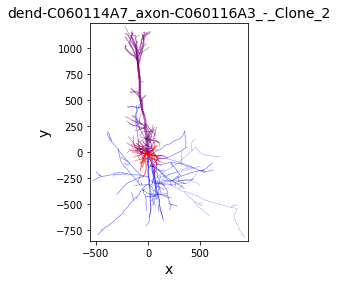

In [6]:
neurom.viewer.draw(neurom.load_neuron('morphology/dend-C060114A7_axon-C060116A3_-_Clone_2.asc'));

## Initializing the model

To load the functionality of the electrical model we load the 'init.hoc' HOC file.

In [7]:
import neuron as nrn # NEURON simulator
nrn.h.load_file("./init.hoc");

The init.hoc has created a function 'create_cell' to instantiate the neuron in the NEURON simulator. As argument it takes a value to enable/disable the synapses of the cell. (1=True, 0=False)

In [8]:
nrn.h.create_cell(1); # argument 1 stands for 'load synapses'

After this function has been called the global name space of the NEURON simulator contains a variable 'cell'. 
Let's create a python variable to point to this object and for the soma:

In [9]:
cell = nrn.h.cell
soma = cell.soma[0]

## Injecting a step current

Now that we have a pointer to the soma of the neuron, we can inject a current into it. As we've learned in another tutorial, we can create an IClamp to inject the current:

In [10]:
# Mention source of amplitude
stimulus = nrn.h.IClamp(0.5, sec=soma)
stimulus.dur = 400 # ms
stimulus.delay = 100  # ms     
stimulus.amp = 0.691907 # nA

The current amplitude is exactly the value used to generate the trace for the highest step current on the [model page](https://bbp.epfl.ch/nmc-portal/microcircuit.html#/metype/L5_TTPC2_cADpyr/details).
The values to recreate the three traces can be retrieved from a file in the model package:

In [11]:
with open('current_amps.dat') as current_file:
    current_content = current_file.read()

print 'File content: ', current_content
holding_current, step1_current, step2_current, step3_current = [float(x) for x in current_content.split()]

print
print 'Holding current: %f nA' % holding_current
print 'Step 1: %f nA' % step1_current
print 'Step 2: %f nA' % step2_current
print 'Step 3: %f nA' % step3_current

File content:  -0.286011 0.5930628 0.6424847 0.6919066

Holding current: -0.286011 nA
Step 1: 0.593063 nA
Step 2: 0.642485 nA
Step 3: 0.691907 nA


The 'holding current' is current the experimentalists inject during the entire recording to hold the neuron at a predefined voltage before the actual stimulus is applied.

The init.hoc also has provided us with a function to enable the recording of the voltage:

In [12]:
nrn.h.create_recording();    #activate recording of activity 

Now we can run the simulation:

In [13]:
nrn.h.tstop = 600 # ms
nrn.h.dt = 0.05 # 
nrn.h.run();

nrn.h.save_recording();

And plot the time/voltage:

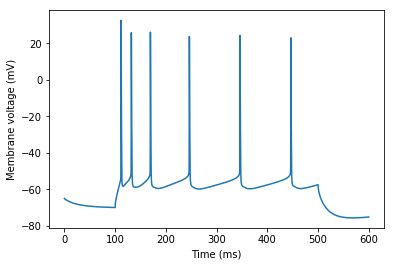

In [14]:
time = nrn.h.time
voltage = nrn.h.voltage

def plot_tv(time_array, voltage_array, show=True, label=None, constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()
    

plot_tv(time, voltage);

## Exercise

To reduce the simulation time, the simulation ends at 600 ms. 
Try to replicate the exact traces on the NMC portal.
The trace shown on the portal is the result of a 3000 ms simulation. The stimulus starts at 700 ms, and last for 2000 ms. Create two iclamps and inject a holding current for the full duration of the simulation, and step current for 2000 ms. Used the amplitudes retrieved from the current_amps.dat file.

## Activating synapses

To handle the synapses of the cell we will make use of 'synapses' attribute of the cell object. E.g. all the synapse objects are stored in the synapse_list attribute. We can print the number of synapses on this neuron: 

In [15]:
print "Number of synapses: ", len(list(cell.synapses.synapse_list))

Number of synapses:  5267


Similarly, all the neurons that are presynaptic to this cell are represented as a netstim object. A netstim is a NEURON mechanism that acts as a virtual cell. It can connect to a synapse and e.g. inject a poisson spike train into the synapse. All the presynaptic netstims are in the netstim_list:

In [16]:
print "Number of pre-synaptic cells: ", len(list(cell.synapses.netstim_list))

Number of pre-synaptic cells:  920


As you can see there are less presynaptic cells than synapses. This is because cells can project to several synapses on the postsynaptic cell at the same time (these are called a multisynaptic connections).

The presynaptic connections are ordered according the morphological type (m-type) of the presynaptic cells.
In the neocortical microcircuit model there are 55 m-types defined. A glossary of all the abreviations used in the m-types is available on the [NMC portal website](https://bbp.epfl.ch/nmc-portal/glossary.html).
The model package we downloaded from the NMC portal has a file that maps every m-type to an integer:

In [17]:
with open('synapses/mtype_map.tsv') as mtype_map_file:
    mtype_map_content = mtype_map_file.read()
print 'integer\tm-type'
print '---------------'
print mtype_map_content

integer	m-type
---------------
0	L1_DAC
1	L1_NGC-DA
2	L1_NGC-SA
3	L1_HAC
4	L1_DLAC
5	L1_SLAC
6	L23_PC
7	L23_MC
8	L23_BTC
9	L23_DBC
10	L23_BP
11	L23_NGC
12	L23_LBC
13	L23_NBC
14	L23_SBC
15	L23_ChC
16	L4_PC
17	L4_SP
18	L4_SS
19	L4_MC
20	L4_BTC
21	L4_DBC
22	L4_BP
23	L4_NGC
24	L4_LBC
25	L4_NBC
26	L4_SBC
27	L4_ChC
28	L5_TTPC1
29	L5_TTPC2
30	L5_UTPC
31	L5_STPC
32	L5_MC
33	L5_BTC
34	L5_DBC
35	L5_BP
36	L5_NGC
37	L5_LBC
38	L5_NBC
39	L5_SBC
40	L5_ChC
41	L6_TPC_L1
42	L6_TPC_L4
43	L6_UTPC
44	L6_IPC
45	L6_BPC
46	L6_MC
47	L6_BTC
48	L6_DBC
49	L6_BP
50	L6_NGC
51	L6_LBC
52	L6_NBC
53	L6_SBC
54	L6_ChC



This map is very useful, because many lists in the model code are ordered according to m-type. So we will store this map in a dictionary for later use: 

In [18]:
mtype_map = {}
for line in mtype_map_content.split('\n')[:-1]:
    n, mtype = line.split()
    mtype_map[mtype] = int(n)
    
print 'Integer for L23_PC: %d' % mtype_map['L23_PC']


Integer for L23_PC: 6


Now we can e.g. enable all the synapses that are projected onto this cell from L23_PC (layer 2/3 pyramidal cell).
The active_pre_mtypes is a NEURON [vector](https://www.neuron.yale.edu/neuron/static/docs/help/neuron/general/classes/vector/vect.html) (it uses the .x syntax to access the elements). The index of the vector is determined by the m-type map. When the value in the vector is 1 all the presynaptic neurons of a particular m-types are active (and inactive when it is 0)

In [19]:
def init_synapses(enabled_mtypes=[]):
    enabled_mtype_ints = [mtype_map[mtype] for mtype in enabled_mtypes]
    
    for i in range(0, int(cell.synapses.n_of_mtypes)): # Loop over all the m-type
        if i in enabled_mtype_ints: # Enable synapses
            cell.synapses.were_active_pre_mtypes.x[i]= 0
            cell.synapses.active_pre_mtypes.x[i] = 1        
        else: # Disable synapses
            cell.synapses.were_active_pre_mtypes.x[i]= 1
            cell.synapses.active_pre_mtypes.x[i] = 0
            
    cell.synapses.update_synapses(nrn.h.synapse_plot); # Update the synapses

init_synapses(enabled_mtypes=['L23_PC'])

When now we run a simulation we see the voltage recorded in the soma 
of the postsynaptic cell when all the L23_PC presynaptic cells are firing a poisson spike train:

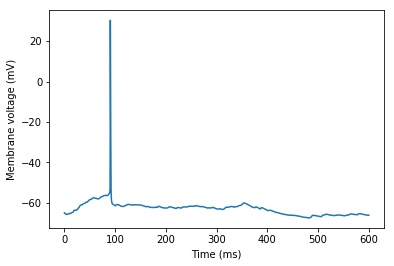

In [20]:
# Remove any previously defined stimulus
if 'stimulus' in locals():
    del stimulus

def run_plot():
    nrn.h.tstop = 600
    nrn.h.dt = 0.05

    nrn.h.run()
    nrn.h.save_recording()

    plot_tv(time, voltage)
    
run_plot()

As you can see the cell is not very active. Let's activate all the Layer 5 Thick Tufted Pyramidal cell connections instead:

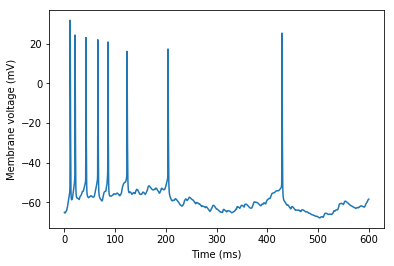

In [21]:
init_synapses(enabled_mtypes=['L5_TTPC2'])
run_plot()

We can also counteract the spiking by e.g. activating some inhibitory interneurons together with the excitatory input

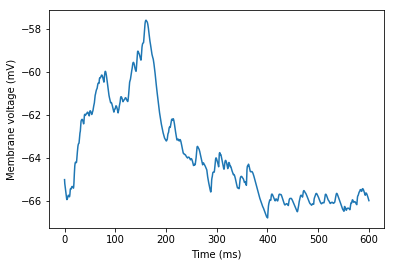

In [22]:
init_synapses(enabled_mtypes=['L23_PC', 'L23_MC', 'L23_BTC', 'L23_LBC', 'L23_SBC', 'L23_DBC'])
run_plot()

One can also influence parameters of e.g. the poisson processes that are creating the spike timings of the presynaptic cells. This is done by manipulating the attributes of the [Netstim](https://www.neuron.yale.edu/neuron/static/docs/help/neuron/neuron/mech.html#NetStim) objects.

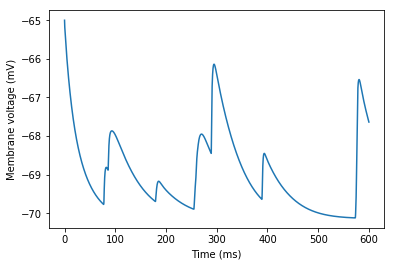

In [23]:
init_synapses(enabled_mtypes=['L5_TTPC2'])

pre_mtype_netstims = list(cell.synapses.pre_mtype_netstimlists)

for netstims in pre_mtype_netstims:
    for netstim in netstims: 
        netstim.interval = 10000 # ms, Average interval between spikes in the Poisson process   

run_plot()